# Decision Tree Regression
A decision tree regression model for predicting product fractions for a specific product for a customer.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor 

## Dataset
Import the dataset and select a customer and a product to run the model on.

In [2]:
raw_df = pd.read_csv("datasets/Hydro_NTNU_prod_mix_dataset_preprocessed.csv", delimiter=";")
df = raw_df[(raw_df['CUSTOMER_ID'] == 3490871) & (raw_df['AREA'] == 'BE UIE') & (raw_df['PRODUCT_TYPE_ID'] == 10) & (raw_df['PRODUCT_CATEGORY'] == 'OUT') & (raw_df['PRODUCT_ID'] == 8482)]

In [3]:
def get_customer_df(customer_id):
    customer_df = raw_df[(raw_df['CUSTOMER_ID'] == customer_id)]
    return customer_df


In [4]:
def get_product_ids_set(customer_df):
    product_ids = list(set(customer_df["PRODUCT_ID"]))
    return product_ids

customer_df = get_customer_df(3490871)
get_product_ids_set(customer_df)

[71424, 8482, 6404, 7589, 4556, 2646, 6463]

In [5]:
customer_df

AREA  PRODUCT_TYPE_ID PRODUCT_CATEGORY  CUSTOMER_ID  PRODUCT_ID  \
9309   BE UIE               10              OUT      3490871        6463   
9310   BE UIE               10              OUT      3490871        8482   
9311   BE UIE               10              OUT      3490871        6404   
9312   BE UIE               10              OUT      3490871        8482   
9313   BE UIE               10              OUT      3490871        2646   
...       ...              ...              ...          ...         ...   
93038  BE UIE               10              OUT      3490871        4556   
93039  BE UIE               10              OUT      3490871        6463   
93040  BE UIE               10              OUT      3490871        6463   
93041  BE UIE               10              OUT      3490871        6463   
93042  BE UIE               10              OUT      3490871        8482   

       PRODUCT_FRACTION  MONTH  YEAR  
9309           0.240000      1  2021  
9310           0.760000      1  2021  
9311           0.240000      1  2020  
9312           0.666667      1  2020  
9313           0.093333      1  2020  
...                 ...    ...   ...  
93038          0.162500      6  2015  
93039          0.510417      4  2015  
93040          0.500000      5  2015  
93041          0.487500      6  2015  
93042          0.225000      6  2015  

[189 rows x 8 columns]

In [6]:
def get_product_id_rows(df, product_id):
    return df[(df['PRODUCT_ID'] == product_id)]

Remove useless attributes.

In [7]:
def remove_useless_attributes(df):
    df = df.loc[:, ['PRODUCT_FRACTION', 'MONTH', 'YEAR']]
    return df
df = remove_useless_attributes(df)
df

PRODUCT_FRACTION  MONTH  YEAR
9310           0.760000      1  2021
9312           0.666667      1  2020
9316           0.111111      1  2019
9320           0.625000      1  2018
9323           0.375000      1  2017
...                 ...    ...   ...
9481           0.500000     12  2020
9483           0.500000     12  2018
9485           0.500000     12  2017
9489           0.166667     12  2015
93042          0.225000      6  2015

[70 rows x 3 columns]

In [8]:
def remove_duplicate_dates(df):
    df = df.drop_duplicates(subset=['YEAR', 'MONTH'], keep='last')
    return df
df = remove_duplicate_dates(df)
df

PRODUCT_FRACTION  MONTH  YEAR
9310           0.760000      1  2021
9312           0.666667      1  2020
9316           0.111111      1  2019
9320           0.625000      1  2018
9323           0.375000      1  2017
...                 ...    ...   ...
9481           0.500000     12  2020
9483           0.500000     12  2018
9485           0.500000     12  2017
9489           0.166667     12  2015
93042          0.225000      6  2015

[70 rows x 3 columns]

In [9]:
# Make all product_fractions to 1
def discretize_fractions(df):
    for row in df.iterrows():
        df.at[row[0], "PRODUCT_INCLUDED"] = True
    return df

In [10]:
df = discretize_fractions(df)
df

PRODUCT_FRACTION  MONTH  YEAR PRODUCT_INCLUDED
9310           0.760000      1  2021             True
9312           0.666667      1  2020             True
9316           0.111111      1  2019             True
9320           0.625000      1  2018             True
9323           0.375000      1  2017             True
...                 ...    ...   ...              ...
9481           0.500000     12  2020             True
9483           0.500000     12  2018             True
9485           0.500000     12  2017             True
9489           0.166667     12  2015             True
93042          0.225000      6  2015             True

[70 rows x 4 columns]

Add missing months (PRODUCT_FRACTION = 0).

In [11]:
def add_missing(df):
    for year in range(2015, 2022):
        for month in range (1, 13):
            if ((not ((df['YEAR'] == year) & (df['MONTH'] == month)).any())):
                if (not (year == 2021 and month > 7)):
                    df = df.append({'PRODUCT_FRACTION': 0, 'PRODUCT_INCLUDED': False, 'MONTH': month, 'YEAR': year}, ignore_index=True)
    return df

df = add_missing(df)
df = df.sort_values(['YEAR', 'MONTH'], ascending=[True, True])

Combine MONTH and YEAR attributes to a DATE attribute.

In [12]:
def combine_month_year(df, value_columns):
    # Drop
    df = df.reset_index(drop=True)
    df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
    df = df.drop(['YEAR', 'MONTH'], axis=1)
    
    # Select columns to include
    selection = []
    selection.append("DATE")
    selection.extend(value_columns)
    df = df[selection]
    df['DATE'] = df['DATE'].dt.strftime('%Y-%m-%d')
    return df

    
df = combine_month_year(df, ["PRODUCT_INCLUDED", "PRODUCT_FRACTION"])
df

DATE PRODUCT_INCLUDED  PRODUCT_FRACTION
0   2015-01-01            False          0.000000
1   2015-02-01             True          0.272727
2   2015-03-01             True          0.200000
3   2015-04-01             True          0.062500
4   2015-05-01             True          0.125000
..         ...              ...               ...
74  2021-03-01             True          0.750000
75  2021-04-01             True          1.000000
76  2021-05-01             True          1.000000
77  2021-06-01             True          1.000000
78  2021-07-01             True          1.000000

[79 rows x 3 columns]

In [13]:
# df['8482'] = list(df["PRODUCT_INCLUDED"])
# new_df = df["PRODUCT_INCLUDED"]

def get_customer_product_matrix(customer_df):
    new_df_dict = {}
    current_df = []
    product_ids = get_product_ids_set(customer_df)
    for product_id in product_ids:
        current_df = get_product_id_rows(customer_df, product_id)
        current_df = remove_useless_attributes(current_df)
        current_df = discretize_fractions(current_df)
        current_df = add_missing(current_df)
        current_df = current_df.sort_values(['YEAR', 'MONTH'], ascending=[True, True])
        current_df = combine_month_year(current_df, ["PRODUCT_INCLUDED", "PRODUCT_FRACTION"])

        new_column = list(current_df["PRODUCT_INCLUDED"])[:79]
        new_df_dict[str(product_id)] = new_column

    #new_df_dict["DATE"] = list(current_df["DATE"])[:79]
    # print(new_df_dict)
    new_df = pd.DataFrame(new_df_dict)
    return new_df

new_df = get_customer_product_matrix(customer_df)
new_df

71424   8482   6404   7589   4556   2646   6463
0    True  False  False  False  False  False   True
1    True   True  False  False  False  False   True
2    True   True  False  False  False  False   True
3    True   True  False  False  False   True   True
4   False   True  False  False  False   True   True
..    ...    ...    ...    ...    ...    ...    ...
74  False   True  False  False  False  False   True
75  False   True  False  False  False  False  False
76  False   True  False  False  False  False  False
77  False   True  False  False  False  False  False
78  False   True  False  False  False  False  False

[79 rows x 7 columns]

In [14]:
def get_product_fractions(customer_df, product_id):
    current_df = get_product_id_rows(customer_df, product_id)
    current_df = add_missing(current_df)
    current_df = current_df.sort_values(['YEAR', 'MONTH'], ascending=[True, True])
    current_df = combine_month_year(current_df, ["PRODUCT_INCLUDED", "PRODUCT_FRACTION"])
    return list(current_df["PRODUCT_FRACTION"])[:79]


In [15]:
def prepare_datasets(X, pred_id, train_count, total_count):
    y = get_product_fractions(customer_df, pred_id)
    
    # Split in training and test datasets
    train_X = X[:train_count]
    train_y = y[:train_count]

    test_X = X[train_count:]
    test_y = y[train_count:]
    
    return train_X, train_y, test_X, test_y

In [16]:
def train_and_test(train_X, train_y, test_X, test_y):
    # create a regressor object
    regressor = DecisionTreeRegressor(random_state = 0)

    # fit the regressor with X and Y data
    regressor.fit(train_X, train_y)

    y_pred = regressor.predict(test_X)
    return y_pred

In [17]:
def get_product_fractions_df(customer_df, pred_id):
    product_df = get_product_id_rows(customer_df, pred_id)
    product_df = remove_useless_attributes(product_df)
    product_df = discretize_fractions(product_df)
    product_df = add_missing(product_df)
    product_df = product_df.sort_values(['YEAR', 'MONTH'], ascending=[True, True])
    product_df = combine_month_year(product_df, ["PRODUCT_FRACTION"])
    return product_df

In [18]:
# Testing code for one product id

pred_id = 8482
customer_id = 622116
customer_df = get_customer_df(customer_id)
X = get_customer_product_matrix(customer_df)

total_count = 79
train_count = 45
test_count = total_count - train_count

train_X, train_y, test_X, test_y = prepare_datasets(X, pred_id, train_count, total_count)

y_pred = train_and_test(train_X, train_y, test_X, test_y)

Plot the product fraction per month.

In [19]:
# df['8482'] = list(df["PRODUCT_INCLUDED"])
# new_df = df["PRODUCT_INCLUDED"]

def get_customer_product_matrix(customer_df):
    new_df_dict = {}
    current_df = []
    product_ids = get_product_ids_set(customer_df)
    for product_id in product_ids:
        current_df = get_product_id_rows(customer_df, product_id)
        current_df = remove_useless_attributes(current_df)
        current_df = remove_duplicate_dates(current_df)
        current_df = discretize_fractions(current_df)
        current_df = add_missing(current_df)
        current_df = current_df.sort_values(['YEAR', 'MONTH'], ascending=[True, True])
        current_df = combine_month_year(current_df, ["PRODUCT_INCLUDED", "PRODUCT_FRACTION"])
        
        # print(len(list(current_df["PRODUCT_INCLUDED"])))
        new_column = list(current_df["PRODUCT_INCLUDED"])[:79]
        new_df_dict[str(product_id)] = new_column

    #new_df_dict["DATE"] = list(current_df["DATE"])[:79]
    # print(new_df_dict)
    new_df = pd.DataFrame(new_df_dict)
    return new_df

new_df = get_customer_product_matrix(customer_df)
new_df

71172  71173  81926   1557  43059  81461  43069  43087  43089  71253  ...  \
0   False  False  False   True  False  False  False  False  False  False  ...   
1   False  False  False   True  False  False  False  False  False  False  ...   
2   False  False  False   True  False  False  False  False  False  False  ...   
3   False  False  False   True  False  False  False  False  False   True  ...   
4   False  False  False   True  False  False  False  False  False  False  ...   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
74  False  False  False  False  False  False  False   True  False  False  ...   
75  False  False   True  False  False  False  False  False  False  False  ...   
76  False  False   True  False   True  False  False   True   True  False  ...   
77  False  False  False  False   True  False  False   True   True  False  ...   
78  False   True  False   True  False  False   True   True  False  False  ...   

    81840  81841  71614   1471  48577  43466  48587  145357  48096  71675  
0   False  False   True   True  False  False  False   False  False  False  
1   False  False   True   True  False  False  False   False  False  False  
2   False  False   True   True  False  False  False   False  False  False  
3   False  False   True  False  False  False  False   False  False  False  
4   False  False   True  False  False  False  False   False  False  False  
..    ...    ...    ...    ...    ...    ...    ...     ...    ...    ...  
74  False  False  False  False   True   True   True   False   True  False  
75  False  False  False  False  False   True  False   False   True  False  
76  False  False  False  False  False   True  False   False   True  False  
77  False  False  False  False  False   True   True    True  False  False  
78  False  False  False  False  False   True   True   False   True  False  

[79 rows x 91 columns]

In [20]:
def get_product_fractions(customer_df, product_id):
    current_df = get_product_id_rows(customer_df, product_id)
    current_df = remove_useless_attributes(current_df)
    current_df = remove_duplicate_dates(current_df)
    current_df = discretize_fractions(current_df)
    current_df = add_missing(current_df)
    current_df = current_df.sort_values(['YEAR', 'MONTH'], ascending=[True, True])
    current_df = combine_month_year(current_df, ["PRODUCT_INCLUDED", "PRODUCT_FRACTION"])
    return list(current_df["PRODUCT_FRACTION"])[:79]

In [21]:
def get_product_fractions_df(customer_df, pred_id):
    product_df = get_product_id_rows(customer_df, pred_id)
    product_df = remove_useless_attributes(product_df)
    product_df = remove_duplicate_dates(product_df)
    product_df = discretize_fractions(product_df)
    product_df = add_missing(product_df)
    product_df = product_df.sort_values(['YEAR', 'MONTH'], ascending=[True, True])
    product_df = combine_month_year(product_df, ["PRODUCT_FRACTION"])
    return product_df
pd.DataFrame(get_product_fractions_df(customer_df, 8482)["PRODUCT_FRACTION"][:79])

PRODUCT_FRACTION
0                0.0
1                0.0
2                0.0
3                0.0
4                0.0
..               ...
74               0.0
75               0.0
76               0.0
77               0.0
78               0.0

[79 rows x 1 columns]

In [22]:
def prepare_datasets(X, pred_id, train_count, total_count):
    y = get_product_fractions(customer_df, pred_id)
    
    # Split in training and test datasets
    train_X = X[:train_count]
    train_y = y[:train_count]

    test_X = X[train_count:]
    test_y = y[train_count:]
    
    return train_X, train_y, test_X, test_y

In [23]:
def train_and_test(train_X, train_y, test_X, test_y):
    # create a regressor object
    regressor = DecisionTreeRegressor(random_state = 0)

    # fit the regressor with X and Y data
    regressor.fit(train_X, train_y)

    y_pred = regressor.predict(test_X)
    return y_pred
regressor = DecisionTreeRegressor(random_state = 0)
print(regressor)

DecisionTreeRegressor(random_state=0)


In [24]:
# Testing code for one product id

pred_id = 8482
customer_id = 622116
customer_df = get_customer_df(customer_id)
X = get_customer_product_matrix(customer_df)

total_count = 79
train_count = 55
test_count = total_count - train_count

train_X, train_y, test_X, test_y = prepare_datasets(X, pred_id, train_count, total_count)

y_pred = train_and_test(train_X, train_y, test_X, test_y)

Plot the product fraction per month.

71424


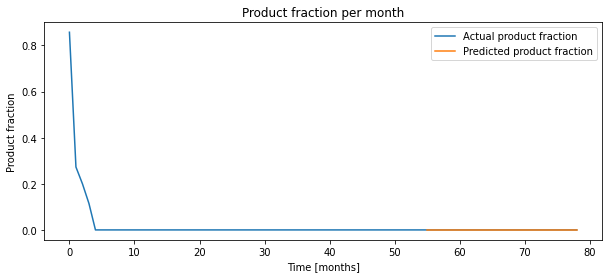

8482


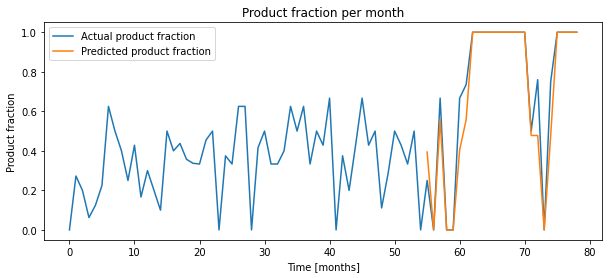

6404


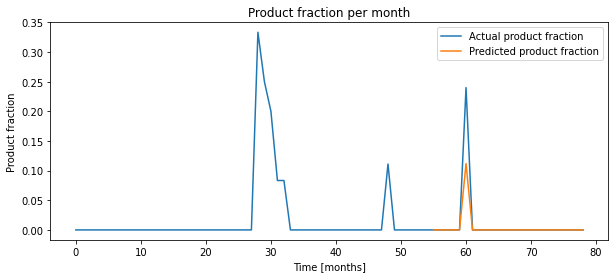

7589


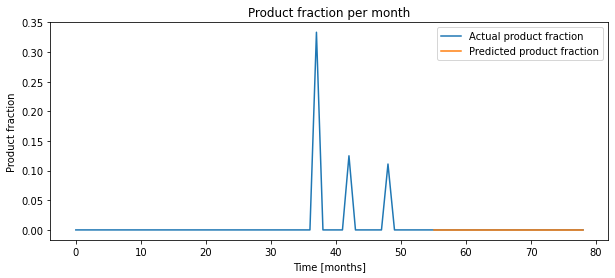

4556


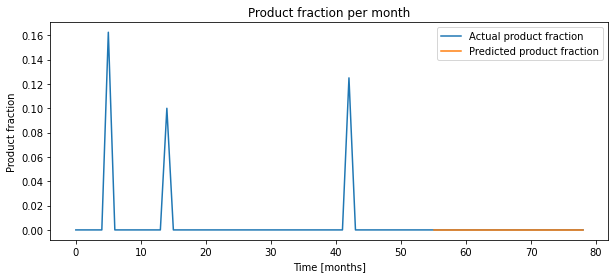

2646


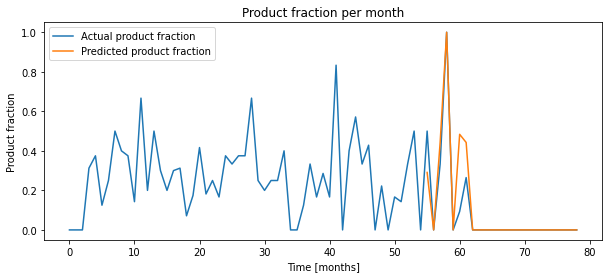

6463


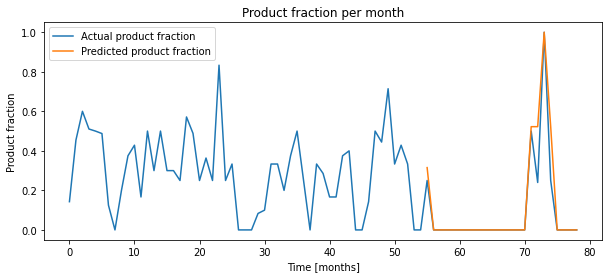

In [30]:
def visualize_prediction(product_fraction_df, y_pred):
    plt.figure(figsize=(10, 4))
    plt.plot(product_fraction_df['PRODUCT_FRACTION'], label="Actual product fraction")
    x_pred = np.linspace(train_count, total_count - 1, total_count - train_count)
    plt.plot(x_pred, y_pred, label="Predicted product fraction")
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True) # labels along the bottom edge are off
    plt.ylabel('Product fraction')
    plt.xlabel('Time [months]')
    plt.title("Product fraction per month")
    plt.legend()
    plt.show()

customer_id = 3490871 # 3490871, 622116, 2193153239, 33856    
customer_df = get_customer_df(customer_id)
X = get_customer_product_matrix(customer_df)
product_ids = get_product_ids_set(customer_df)
total_count = 79
train_count = 55
test_count = total_count - train_count
result_dict = {}
for product_id in product_ids:
    # Prepare dataset
    train_X, train_y, test_X, test_y = prepare_datasets(X, product_id, train_count, total_count)

    # Train and get the predicted data
    y_pred = train_and_test(train_X, train_y, test_X, test_y)
    
    # Store the result
    result_dict[str(product_id)] = y_pred
    
# Scale the result so they each order sum to 1
result_df = pd.DataFrame(result_dict)
for row in result_df.iterrows():
    current_sum = sum(row[1])
    if current_sum == 0:
        continue
    scale = 1 / current_sum
    for product_id in product_ids:
        result_df.at[row[0], str(product_id)] = row[1][str(product_id)] * scale
    result_sum = sum(row[1])
        
avg_mse = 0
for product_id in product_ids:
    print(product_id)
    product_df = get_product_fractions_df(customer_df, product_id)
    
    visualize_prediction(product_df, result_df[str(product_id)])
    
    avg_mse += mean_squared_error(product_df["PRODUCT_FRACTION"].tail(test_count), result_df[str(product_id)])
avg_mse = avg_mse / len(product_ids)

In [26]:
get_product_fractions_df(customer_df, 8482)["PRODUCT_FRACTION"].tail(test_count)

55    0.250000
56    0.000000
57    0.666667
58    0.000000
59    0.000000
60    0.666667
61    0.735294
62    1.000000
63    1.000000
64    1.000000
65    1.000000
66    1.000000
67    1.000000
68    1.000000
69    1.000000
70    1.000000
71    0.500000
72    0.760000
73    0.000000
74    0.750000
75    1.000000
76    1.000000
77    1.000000
78    1.000000
Name: PRODUCT_FRACTION, dtype: float64

In [27]:
result_df["8482"]

0     0.394072
1     0.000000
2     0.557540
3     0.000000
4     0.000000
5     0.404491
6     0.557540
7     1.000000
8     1.000000
9     1.000000
10    1.000000
11    1.000000
12    1.000000
13    1.000000
14    1.000000
15    1.000000
16    0.477679
17    0.477679
18    0.000000
19    0.477679
20    1.000000
21    1.000000
22    1.000000
23    1.000000
Name: 8482, dtype: float64

In [28]:
mse = mean_squared_error(get_product_fractions_df(customer_df, 8482)["PRODUCT_FRACTION"].tail(test_count), result_df["8482"])
mse

0.011973361854097244

In [29]:
avg_mse

0.004178919176020204